In [187]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import sys

In [284]:
def parse_labels(lbls):
    """takes a string and returns list of numeric labels"""
    result = lbls[2:][:-2]
    result = result.split("', '")
    return result

df = pd.read_csv('train_imgs.csv').copy()
df.index = df.img_id.astype(int)

def update_progress(progress):
    """Displays or updates a console progress bar
    Accepts a float between 0 and 1. Any int will be converted to a float.
    A value under 0 represents a 'halt'.
    A value at 1 or bigger represents 100%
    """
    barLength = 25 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rProgress: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), round(progress*100, 2), status)
    sys.stdout.write(text)
    sys.stdout.flush()

def features_to_sparse(df, filename='sparse_features.npz'):
    """Converts labels to sparse matrix. Tries loading
    file; if fails, does all the work and saves it (takes a bit.)
    """
    try:
        result = load_npz(filename)
        return result
    except:
        print('file not found. Creating...')
    total_rows = len(df)
    row = []
    col = []
    data = []
    for idx in df.index:
        progress = idx/total_rows
        update_progress(progress)
        df_row = df.loc[idx]
        labels = parse_labels(df_row.lbls)
        for lbl in labels:
            row.append(idx-1)
            col.append(int(lbl)-1)
            data.append(1)
            
    row, col, data = np.array(row), np.array(col), np.array(data)
    result = csr_matrix((data, (row, col)), shape=(max(row)+1, max(col)+1))
    save_npz(filename, result)
    return result

mat = features_to_sparse(df)

In [56]:
totals = mat.sum(axis=0)
totals = [totals[0, i] for i in range(228)]

In [140]:
n_classes = 10
totals = np.array(totals)
top_n = np.argpartition(totals, -n_classes)[-n_classes:]
check = totals[top_n].copy()
topn_frac = check.sum()/totals.sum()
print('{}% of instances belong to top {} classes.'.format(round(topn_frac*100, 2), n_classes))
print('The top {} classes are: '.format(n_classes))
#add one because of zero indexing
print(top_n + 1)

43.83% of instances belong to top 10 classes.
The top 10 classes are: 
[ 62  53 106 222  66 214  17 171 153 105]


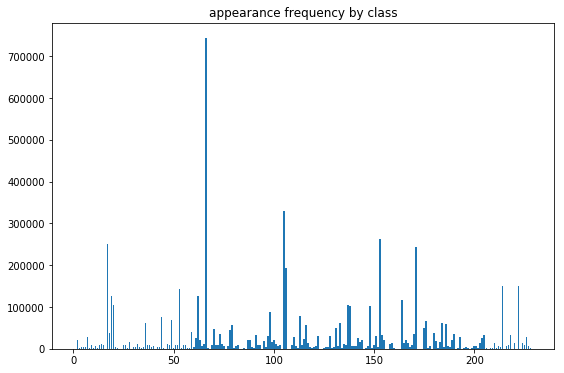

In [141]:
plt.figure(figsize=(9, 6));
plt.bar(x=range(1,229), height=totals);
plt.title('appearance frequency by class');

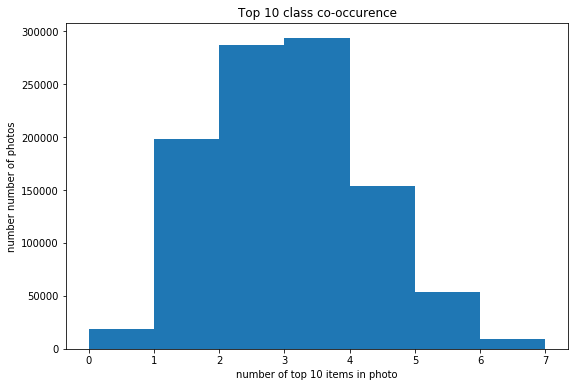

In [142]:
trunc_matrix = mat[:, top_n]
plt.figure(figsize=(9,6))
plt.hist(np.array(trunc_matrix.sum(axis=1))[:, 0], bins=7);
plt.title('Top {} class co-occurence'.format(n_classes));
plt.xlabel('number of top {} items in photo'.format(n_classes));
plt.ylabel('number number of photos');

In [98]:
len(np.argwhere(np.array(trunc_matrix.sum(axis=1))[:, 0]==0))/len(df)

0.018174667633932093

In [304]:
def download_image(url):
    """takes a url and returns a PIL image object."""
    try:
        response = requests.get(url)
    except:
        print('request failed.')
        return
    if response.status_code in [403, 404]:
        print('image not found.')
        return
    try:
        img = Image.open(BytesIO(response.content))
    except:
        print('could not open image.')
        return
    return img

def image_from_url(idx, df=df):
    """uses dataframe and index to lookup url
    and returns PIL image."""
    row = df.loc[idx]
    url = row['url']
    image = download_image(url)
    return image

def image_from_disk(idx, df=df, path_to_images='./train_imgs/'):
    """Loads an image from disk according to index idx.
    returns PIL image.
    """
    file = path_to_images + str(idx) + '.png'
    image = Image.open(file)
    return image

def image_as_tensor(image, xy_dims=(256, 256)):
    """takes a PIL image (image) and returns
    a numpy array with shape xy_dims (color channels
    last) scaled between 0 and 1.
    """
    res = image.resize(xy_dims)
    res = np.array(res)/255
    return res

def get_image(idx, filepath='./train_imgs/', df=df, xy_dims=(256, 256)):
    """attempts to load image from disk. If not found,
    downloads and saves to disk."""
    try:
        img = image_from_disk(idx, path_to_images=filepath)
        return image_as_tensor(img)
    except:
        img = image_from_url(idx, df=df)
        img = img.resize(xy_dims)
        img.save(filepath + str(idx) + '.png')
        return image_as_tensor(img)
    
def input_batch(indices, filepath='./train_imgs/', df=df, xy_dims=(256, 256)):
    """Creates an input batch with given list of indices."""
    batch = []
    for idx in indices:
        batch.append(get_image(idx, filepath=filepath, df=df, xy_dims=xy_dims))
    batch = np.array(batch)
    return batch
    
def output_batch(indices, matrix=trunc_matrix, n_placeholders=2):
    """Creates an output batch with given list of indices."""
    batch = []
    for idx in indices:
        label_array = trunc_matrix[idx,:].toarray()[0,:]
        to_append = np.ones(n_placeholders)
        final_array = np.append(label_array, to_append)
        batch.append(final_array)
    batch = np.array(batch)
    return batch

In [217]:
def classify_ideal_images(df=df, model_path='ideal_classifier.h5', batch_size=10):
    """Applies classifier model to images in df and returns a prediction vector
    of length len(df)"""
    from keras.models import load_model
    model = load_model(model_path)
    result = np.array([])
    batch_begin = 1
    batch_end = batch_begin + batch_size
    while batch_begin < max(df.index):
        progress = batch_begin/len(df)
        update_progress(progress)
        indices = [i for i in range(batch_begin, batch_end)]
        batch_begin += batch_size
        batch_end += min(batch_size, len(df)-batch_end)
        batch = input_batch(indices)
        prediction = model.predict(batch)
        result = np.append(result, prediction)
        np.save('ideal_image_classes.npy', result)
    return result

In [275]:
ideal_predictions = np.empty(len(df))
ideal_predictions[:] = np.nan

In [276]:
shit_img = np.load('shit_img.npy')
def check_ideal(idx, model, shit_img=shit_img):
    """Runs prediction on image to see if ideal."""
    as_batch = input_batch([idx])
    if np.array_equal(as_batch[0, :, :, :], shit_img):
        return 0
    else:
        return model.predict(as_batch)[0, 0]

def train_gen(
    batch_size=10,
    df=df, 
    shuffle=False, 
    ideal_predictions=ideal_predictions, 
    ideal_model_path='ideal_classifier.h5'):
    """Generates training batches."""
    from keras.models import load_model
    ideal_model = load_model(ideal_model_path)
    current_image = 0
    while True:
        batch_indices = []
        while len(batch_indices) < batch_size:
            current_image += 1
            if current_image > len(df):
                current_image = 1
            if shuffle:
                current_image = np.random.randint(1, len(df))
            if np.isnan(ideal_predictions[current_image-1]):
                ideal_predictions[current_image-1] = check_ideal(current_image, ideal_model)
            if ideal_predictions[current_image-1]>.5:
                batch_indices.append(current_image)
            elif ideal_predictions[current_image-1]<.5:
                pass
            else:
                raise Exception('problem classifying image as ideal.')
        X = input_batch(batch_indices)
        Y = output_batch(batch_indices)
        yield X, Y

In [321]:
val_data = pd.read_csv('validation.csv')
val_data.index = val_data.img_id.astype(int)
val_mat = features_to_sparse(val_data, 'validation_matrix.npz')
trunc_val = val_mat[:, top_n]


def val_gen(batch_size=10, df=val_data, mat=trunc_val, filepath='./val_imgs/'):
    """Generates validation batches."""
    current_image = 0
    while True:
        batch_indices = []
        while len(batch_indices) < batch_size:
            current_image += 1
            if current_image > len(df):
                current_image = 1
            batch_indices.append(current_image)
        X = input_batch(batch_indices, filepath=filepath, df=df)
        Y = output_batch(batch_indices, matrix=mat)
        yield X, Y

In [ ]:
vg = val_gen(batch_size=100)
for n in range(100):
    X, Y = next(vg)
    plt.imshow(X[2, :,  :, :])
    plt.show();

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-304-e38f5a44b421>", line 47, in get_image
    img = image_from_disk(idx, path_to_images=filepath)
  File "<ipython-input-304-e38f5a44b421>", line 31, in image_from_disk
    image = Image.open(file)
  File "/home/alliedtoasters/miniconda3/envs/dev1/lib/python3.6/site-packages/PIL/Image.py", line 2543, in open
    fp = builtins.open(filename, "rb")
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alliedtoasters/miniconda3/envs/dev1/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-324-36405cc3c852>", line 3, in <module>
    X, Y = next(vg)
  File "<ipython-input-321-b9bbec2fbf13>", line 17, in val_gen
    X = input_batch(batch_indices, filepath=filepath, df=df)
  File "<ipython-input-304-e38f5a44b421>", line 59, in input_batch
    ba

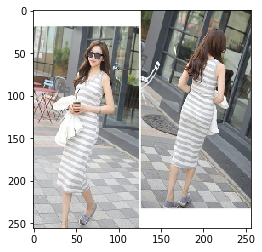

In [310]:
plt.imshow(X[2, :,  :, :])